# Plotting PS Fits

This script will plot the Guinier-Porod fits of the pure deuterated polystyrene control samples. For those samples without available USANS data, the Porod fit alone will be plotted. 

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

# set the following path to the sasview source code if needed for your os
# sys.path.append(r'C:path\to\sasview\src')
import sas

## Loading Data and Meta-Data

In [2]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual weight percentages
data = np.loadtxt('../../data/uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual = {}
for key, tar, act, stdev in data:
    actual[key] = act


In [3]:
# loading SANS and smeared USANS data
data_dir = '../../data/sans/Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)

We will only be plotting fits for the deuterated polystyrene samples (hydrogenated polystyrene sample was not fit).

In [4]:
ps_keys = [key for key, value in target.items() if value == 0 and matrix[key] == 'Polystyrene-D8' and key in sans_data.keys()]
ps_keys


[21, 28, 35, 113, 114, 309, 310, 409, 506]

Loading background values from initial power law fits of PS data.

In [5]:
background_files = [file for file in os.listdir('../data/sans/PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../data/sans/PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)

Loading the common porod exponent and initial scale values from the second power law fits of the PS data. The porod exponent will be used for the final Guinier_Porod fits, and the scales may change slightly depending on those final fits as well. The `scales` dictionary will get updated as necessary.

In [6]:
power_law_fit_info = pd.read_json('../data/sans/PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
scales = {}

for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_95p = value['p95']
    else:
        key = int(key.split()[0])
        scales[key] = (value['best'], value['p95'])

Loading the final 's' dimensionality constant of the Guinier_Porod fit, updated scales and final Rg values.

In [7]:
guinier_porod_fit = pd.read_json('../data/sans/PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
adjusted_scales = {} # scales from guinier_porod fit corrected to scale of Porod component only
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        scales[key] = (value['best'], value['p95'])
        
        
for key in rgs.keys():
    q1 = (1/rgs[key][0]) * np.sqrt((ps_porod_exp - ps_s)*(3-ps_s)/2)
    new_scale = scales[key][0] * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    new_95p = np.array(scales[key][1]) * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    adjusted_scales[key] = (new_scale, list(new_95p))
    
        

## Creating Figures of Polysytrene SANS data with Guinier-Porod Fits

In [10]:
os.makedirs('../data/sans/PS_Fitting/ps_fit_results/figures', exist_ok=True)
for key in scales.keys():
    
    plt.figure(figsize=(6,6))
    
    # determinging whether to use Guinier-Porod (available USANS data) or Porod (no USANS data) model
    if key in rgs.keys():
        kernel = load_model('guinier_porod')
        model = Model(kernel, scale=scales[key][0], rg=rgs[key][0], s=ps_s, porod_exp=ps_porod_exp, background=backgrounds[key][0])
    else:
        kernel = load_model('power_law')
        model = Model(kernel, scale=scales[key][0], power=ps_porod_exp, background=backgrounds[key][0])
    
    # plotting the SANS data
    sans = sans_data[key]
    sans.dx = sans.dx - sans.dx
    plt.errorbar(sans.x, sans.y, yerr=sans.dy, fmt='o', c='black', zorder=1, ms=4)
    sans_experiment = Experiment(data=sans, model=model)
    sans_problem = FitProblem(sans_experiment)
    
    # plotting the fit
    plt.plot(sans.x, sans_problem.fitness.theory(), c='yellow', linewidth=2, zorder=10)
    
    # adding the USANS data and fit if applicable
    if key in usans_data.keys():
        usans = usans_data[key]
        # plotting USANS data
        plt.errorbar(usans.x, usans.y, yerr=usans.dy, fmt='o', c='black', zorder=1, ms=4)
        usans_experiment = Experiment(data=sans, model=model)
        usans_smearing = sasmodels.resolution.Slit1D(usans.x, 0.117)
        usans_experiment.resolution = usans_smearing
        usans_problem = FitProblem(usans_experiment)
        # plotting fit across USANS q-range
        plt.plot(usans.x, usans_problem.fitness.theory(), c='yellow', linewidth=2, zorder=10)

    # setting plot axes to log scale
    plt.xscale('log')
    plt.yscale('log')

    # adding axis labels
    plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
    plt.ylabel(r'I(Q) (cm$^{-1}$)', fontsize=16)

    # formatting axis tickmarks
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # setting x and y plot limits
    plt.ylim(1e-03, 1e11)
    plt.xlim(0.00002, 0.3)

    # setting plot title
    plt.title('Polystyrene-D8 from '+ solvent_names[key] + '\n(Sample ' + str(key) + ')', fontsize=16)

    # formatting and saving figure
    plt.tight_layout()
    plt.savefig('../data/sans/PS_Fitting/ps_fit_results/figures/PS_' + str(key) + '_Guinier_Porod_Fit.png', dpi=400)
    plt.close()




## Plotting Fitting Results with Uncertainty Analysis

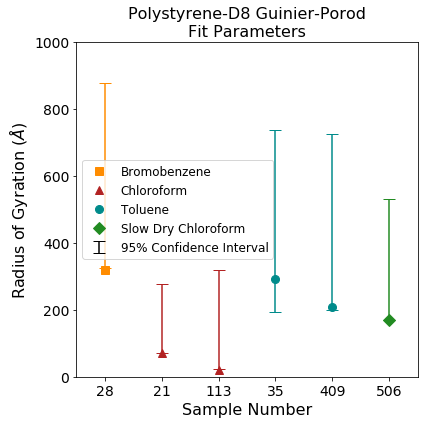

In [11]:
# Plotting radius of gyration
plt.figure(figsize=(6,6))

# Samples cast from Bromobenzene
plot_keys_bb = []
plot_rgs_bb = []
plot_95_high_bb = []
plot_95_low_bb = []
for key in ps_keys:
    if (key in rgs.keys() and solvent_names[key] == 'Bromobenzene'):
        plot_keys_bb.append(key)
        plot_rgs_bb.append(rgs[key][0])
        plot_95_high_bb.append(rgs[key][1][1])
        plot_95_low_bb.append(rgs[key][1][0])
plot_index_bb = np.arange(0,len(plot_keys_bb))
plot_middle_bb = (np.array(plot_95_high_bb) + np.array(plot_95_low_bb))/2

plt.errorbar(plot_index_bb, np.array(plot_rgs_bb), fmt = 's', c='darkorange', label='Bromobenzene', ms=8)
plt.errorbar(plot_index_bb, plot_middle_bb, yerr=plot_95_high_bb-plot_middle_bb, capsize=6, fmt = 'none', c='darkorange', label=None)

# Samples cast from Chloroform
plot_keys_cf = []
plot_rgs_cf = []
plot_95_high_cf = []
plot_95_low_cf = []
for key in ps_keys:
    if (key in rgs.keys() and solvent_names[key] == 'Chloroform'):
        plot_keys_cf.append(key)
        plot_rgs_cf.append(rgs[key][0])
        plot_95_high_cf.append(rgs[key][1][1])
        plot_95_low_cf.append(rgs[key][1][0])
plot_index_cf = np.arange(0,len(plot_keys_cf)) + len(plot_index_bb)
plot_middle_cf = (np.array(plot_95_high_cf) + np.array(plot_95_low_cf))/2

plt.errorbar(plot_index_cf, np.array(plot_rgs_cf), fmt = '^', c='firebrick', label='Chloroform', ms=8)
plt.errorbar(plot_index_cf, plot_middle_cf, yerr=plot_95_high_cf-plot_middle_cf, capsize=6, fmt = 'none', c='firebrick', label=None)

# Samples cast from Toluene
plot_keys_tol = []
plot_rgs_tol = []
plot_95_high_tol = []
plot_95_low_tol = []
for key in ps_keys:
    if (key in rgs.keys() and solvent_names[key] == 'Toluene'):
        plot_keys_tol.append(key)
        plot_rgs_tol.append(rgs[key][0])
        plot_95_high_tol.append(rgs[key][1][1])
        plot_95_low_tol.append(rgs[key][1][0])
plot_index_tol = np.arange(0,len(plot_keys_tol)) + plot_index_cf[-1] + 1
plot_middle_tol = (np.array(plot_95_high_tol) + np.array(plot_95_low_tol))/2

plt.errorbar(plot_index_tol, np.array(plot_rgs_tol), fmt = 'o', c='darkcyan', label='Toluene', ms=8)
plt.errorbar(plot_index_tol, plot_middle_tol, yerr=plot_95_high_tol-plot_middle_tol, capsize=6, fmt = 'none', c='darkcyan', label=None)


# Samples cast from Chloroform - Slow Dry
plot_keys_cf_slow = []
plot_rgs_cf_slow = []
plot_95_high_cf_slow = []
plot_95_low_cf_slow = []
for key in ps_keys:
    if (key in rgs.keys() and solvent_names[key] == 'Slow Dry Chloroform'):
        plot_keys_cf_slow.append(key)
        plot_rgs_cf_slow.append(rgs[key][0])
        plot_95_high_cf_slow.append(rgs[key][1][1])
        plot_95_low_cf_slow.append(rgs[key][1][0])
plot_index_cf_slow = np.arange(0,len(plot_keys_cf_slow)) + plot_index_tol[-1] + 1
plot_middle_cf_slow = (np.array(plot_95_high_cf_slow) + np.array(plot_95_low_cf_slow))/2

plt.errorbar(plot_index_cf_slow, np.array(plot_rgs_cf_slow), fmt = 'D', c='forestgreen', label = 'Slow Dry Chloroform', ms=8)
plt.errorbar(plot_index_cf_slow, plot_middle_cf_slow, yerr=plot_95_high_cf_slow-plot_middle_cf_slow, capsize=6, fmt = 'none', c='forestgreen', label=None)
   
plt.errorbar([-10], [-10], yerr=[20], capsize=6, fmt = 'none', c='black', label='95% Confidence Interval')


# Formatting and Saving the Plot
plt.xlabel(r'Sample Number', fontsize=16)
plt.ylabel(r'Radius of Gyration ($\AA$)', fontsize=16)

plot_index_all = np.hstack((plot_index_bb, plot_index_cf, plot_index_tol, plot_index_cf_slow))
plot_keys_all = plot_keys_bb + plot_keys_cf + plot_keys_tol + plot_keys_cf_slow
plt.xticks(ticks=plot_index_all, labels=plot_keys_all, fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(0,1000)
plt.xlim(-0.5,plot_index_cf_slow[-1]+0.5)

plt.legend(fontsize=12)

plt.title('Polystyrene-D8 Guinier-Porod\nFit Parameters', fontsize=16)

plt.tight_layout()
plt.savefig('../data/sans/PS_Fitting/ps_fit_results/figures/PS_Rg.png', dpi=400)




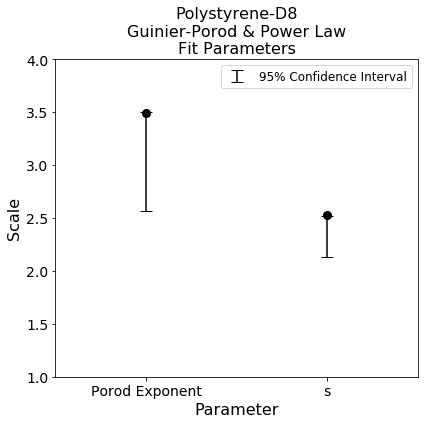

In [12]:
#Plotting Porod Exponent and 's' dimensionality constant
plt.figure(figsize=(6,6))

param_index = [1,2]
param_values = [ps_porod_exp, ps_s]
param_upper = np.array([ps_porod_95p[1], ps_s_95[1]])
param_lower = np.array([ps_porod_95p[0], ps_s_95[0]])
param_middle = (param_upper + param_lower)/2
param_labels = ['Porod Exponent', 's']

plt.errorbar(param_index, param_values, fmt='o', label=None, color='black', ms=8)
plt.errorbar(param_index, param_middle, yerr=param_upper-param_middle, color='black', capsize=6, fmt='none', label='95% Confidence Interval')

plt.xlabel(r'Parameter', fontsize=16)
plt.ylabel(r'Scale', fontsize=16)

plt.xticks(ticks=param_index, labels=param_labels, fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(1,4)
plt.xlim(0.5,2.5)

plt.legend(fontsize=12)

plt.title('Polystyrene-D8\nGuinier-Porod & Power Law\nFit Parameters', fontsize=16)

plt.tight_layout()
plt.savefig('../data/sans/PS_Fitting/ps_fit_results/figures/PS_porod_s.png', dpi=400)


In [13]:
for key in rgs.keys():
    rg = rgs[key][0]
    q1 = (1/rg)*np.sqrt((ps_porod_exp-ps_s)*(3-ps_s)/2)
    print(q1)

0.022135740687458265
0.006851530433955453
0.001497672625675992
0.001634772963756195
0.002289784429454573
0.002825117360033294
